In [1]:
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers.merging import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import EarlyStopping
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io
from PIL import Image, ImageFilter
import cv2
import os
import requests
import pandas as pd
from urllib.request import urlopen

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.layers.activation.prelu import PReLU
from keras.layers.reshaping.cropping2d import Cropping2D

In [3]:
from roughviz.charts import Line
from cutecharts.charts import Line
from keras.callbacks import LearningRateScheduler


In [4]:
path = "photos/train/"
testPath = "photos/test/"

In [5]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(path, target_size=(256,256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


In [6]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(testPath, target_size=(256, 256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


# **Convolutional Neural Network**

## Model Testing Ideas:

* Using different types of activation functions. 
    - PreLU
    - <mark>Leaky ReLU</mark>
    - ReLU
* Changing the validation
    - <mark>with</mark> or without validation set
    - validation steps
* Changing the complexity of the model. 
    - conv2D based network with incrementing filter sizes until 256 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 128 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 64 and decrementing back to 16
    - only increments
* Using different preprocessing techniques
    - adding blur to images before entering the network
    - trying differently sized images
    - maybe some kind of other smoothing or denoising effect
* Trying different learning rates
* Trying different optimizers
* Image Augmentation
* Different Datasets

In [481]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [482]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [483]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [484]:
X_[0].shape

(256, 256)

In [485]:
X_test[0].shape

(256, 256)

In [486]:
from keras.layers.core.dense import Dense
from keras.layers import Dropout

In [487]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [488]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [524]:
initial_learning_rate = 0.01
epochs = 36
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    print("lr: " + str(round(lr,2)))
    return lr * (1 / (1 + decay * epoch))

In [526]:
0.01*(1/(1+decay))

0.009991673605328894

In [530]:
initial_learning_rate/(1+(2*decay))

0.009983361064891847

In [525]:
lr_time_based_decay(1,initial_learning_rate)

lr: 0.01


0.009991673605328894

In [513]:
LEARNING_RATE = 0.01
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error', metrics=["acc"])
Model_Colourization.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_157 (Conv2D)            (None, 256, 256, 16  160         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_151 (LeakyReLU)    (None, 256, 256, 16  0           ['conv2d_157[0][0]']             
                                )                                                          

In [514]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)
#history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[es])
history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=60, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/12


C:\Users\jrsco\AppData\Local\Temp\ipykernel_37464\673517769.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=60, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


5/5 [==============================] - 33s 7s/step - loss: 0.0661 - acc: 0.4837 - val_loss: 0.9909 - val_acc: 0.9678 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009991673381997586.
Epoch 2/12
5/5 [==============================] - 29s 7s/step - loss: 0.0341 - acc: 0.6473 - val_loss: 0.5944 - val_acc: 0.9679 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009975048671546275.
Epoch 3/12
5/5 [==============================] - 29s 7s/step - loss: 0.0256 - acc: 0.6240 - val_loss: 0.9994 - val_acc: 0.9842 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009950173280185595.
Epoch 4/12
5/5 [==============================] - 30s 7s/step - loss: 0.0190 - acc: 0.3866 - val_loss: 0.8802 - val_acc: 0.9922 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009917116033971506.
Epoch 5/12
5/5 [==============================] - 33s 8s/step - loss: 0.0169 - acc: 0.6293 - val_loss: 0.6307 - val_acc: 0.0399 - l

In [515]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [516]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [494]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [531]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 370ms/step
Prediction made
reshaped


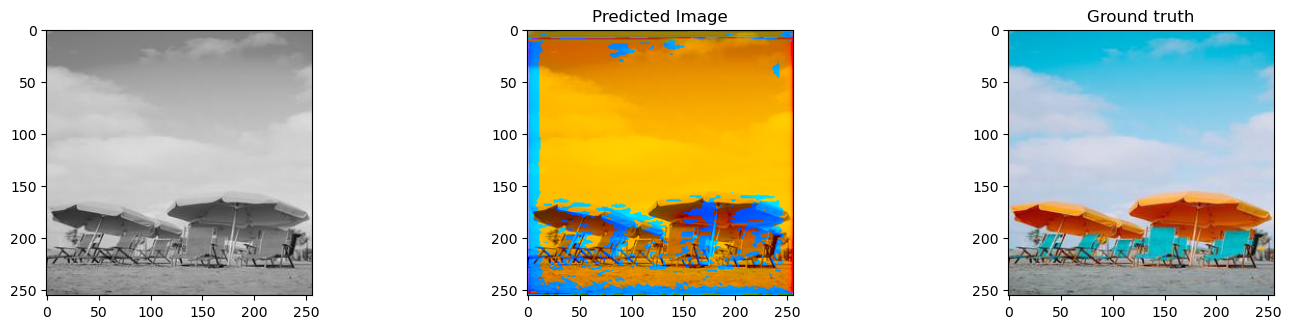

In [532]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

# **Autoencoder Method**

## Setup

In [7]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [9]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [10]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [31]:
def InstantiateAutoencoderModel(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(512,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(512,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    concat_ = concatenate([model_, in_]) 

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(16,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
#    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)
    model_ = UpSampling2D((2,2))(model_)    

    return model_

In [26]:
def initAutoEncoder(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)


    print(model_)
    print(in_)
    
#    model_ = Dropout(rate=0.2)(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(256, (3,3), padding="same", strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(128, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(64, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(32, (3,3), padding="same", strides=1)(model_)

    model_ = Conv2D(16, (3,3), padding="same", strides=1)(model_)

    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)
   # model_ = UpSampling2D((2,2))(model_)    

    print(model_)
    print(in_)

    return model_

In [16]:
from keras.layers import Flatten
from keras.layers import Dense

In [26]:
# Input layer
input_img = Input(shape=(256, 256, 1))

# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Flatten and Dense layers for non-spatial feature extraction
#flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(pool2)
dense2 = Dense(64, activation='relu')(dense1)
print(dense2)
# Decoder
upsample1 = UpSampling2D((2, 2))(dense2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(upsample1)
upsample2 = UpSampling2D((2, 2))(conv3)
decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(upsample2)

# Define the model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print the model summary
autoencoder.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='dense_9/Relu:0', description="created by layer 'dense_9'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                

In [32]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateAutoencoderModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [556]:
from keras.losses import MeanAbsolutePercentageError

In [33]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss="mse", metrics=["acc"])
Model_Colourization.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_33 (LeakyReLU)     (None, 256, 256, 64  0           ['conv2d_36[0][0]']              
                                )                                                           

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                8)                                                                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 256, 256, 12  512        ['leaky_re_lu_41[0][0]']         
 ormalization)                  8)                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 256, 256, 64  73792       ['batch_normalization_32[0][0]'] 
                                )                                                                 
                                                                                                  
 leaky_re_lu_42 (LeakyReLU)     (None, 256, 256, 64  0           ['conv2d_45[0][0]']              
                                )                                                                 
          

In [575]:
initial_learning_rate = 0.001
epochs = 12
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [552]:
from keras.callbacks import LearningRateScheduler

In [34]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)

history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])

Epoch 1/12


C:\Users\jrsco\AppData\Local\Temp\ipykernel_23196\3835236990.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jrsco\AppData\Local\Temp\ipykernel_23196\3835236990.py", line 8, in <module>
      history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [1,1024,1024,2] vs. [1,256,256,2]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_8831]

In [15]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [16]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [17]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [22]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 1s 940ms/step
Prediction made
reshaped


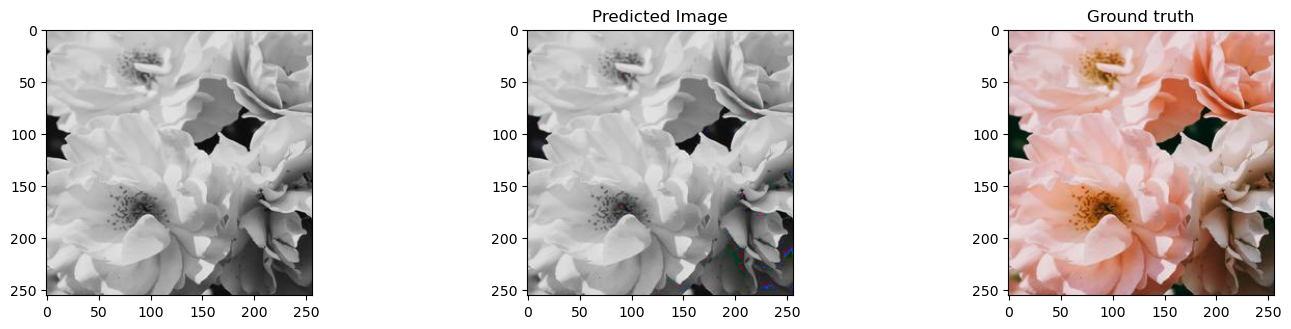

In [23]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)